Dataset Merging

In [13]:
import pandas as pd
import os

# Folder containing the CSV files
folder = r"C:\Users\DELL\OneDrive\Desktop\skill"

# List of files to merge
files = [
    'UNSW_2018_IoT_Botnet_Full5pc_1.csv',
    'UNSW_2018_IoT_Botnet_Full5pc_2.csv',
    'UNSW_2018_IoT_Botnet_Full5pc_3.csv',
    'UNSW_2018_IoT_Botnet_Full5pc_4.csv'
]

# Columns that should be read as strings (update with actual column names)
dtype_overrides = {
    'column_3_name': str,
    'column_5_name': str,
    'column_13_name': str,
    'column_45_name': str,
    'column_46_name': str
}

# Read and merge all CSVs in chunks
combined_df = pd.DataFrame()
for file in files:
    filepath = os.path.join(folder, file)
    for chunk in pd.read_csv(filepath, chunksize=100000, dtype=dtype_overrides, low_memory=False):
        combined_df = pd.concat([combined_df, chunk], ignore_index=True)

# Save to new CSV
combined_df.to_csv(os.path.join(folder, 'combined_dataset.csv'), index=False)
print("Merged file saved successfully.")


Merged file saved successfully.


Columns in the dataset:
['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory']
Analyzing column: 'attack'
Processing data in chunks...
Processed 1,000,000 records...
Processed 2,000,000 records...
Processed 3,000,000 records...

Total records analyzed: 3,668,522

Top categories in 'attack':
attack
1    3668045.0
0        477.0
dtype: float64


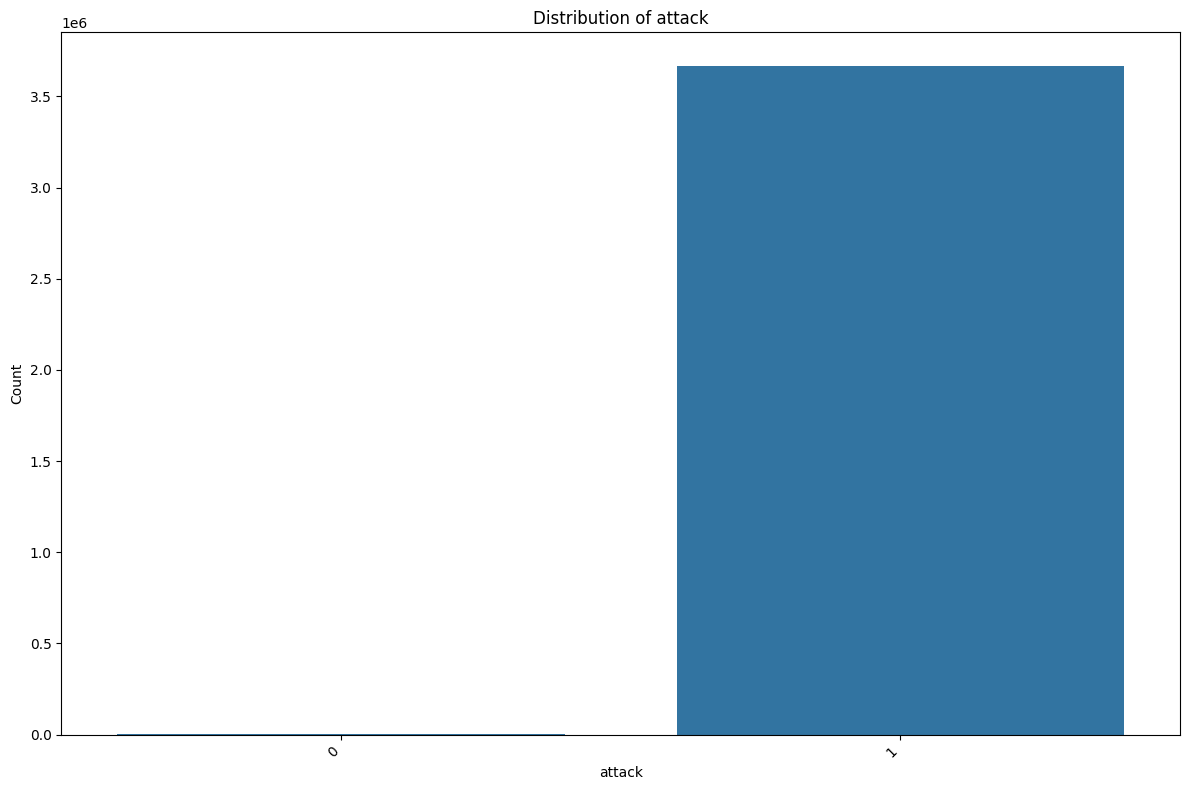


Percentage distribution of top categories:
attack
1    99.99%
0     0.01%
dtype: object

Counts saved to: C:\Users\DELL\OneDrive\Desktop\skill\attack_counts.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Path to your combined dataset
file_path = r"C:\Users\DELL\OneDrive\Desktop\skill\combined_dataset.csv"

# Check if the file exists
if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
    exit()

# Load a small sample to see the columns
df_sample = pd.read_csv(file_path, nrows=5)
print("Columns in the dataset:")
print(df_sample.columns.tolist())

# Select a column that exists in your dataset
column_to_analyze = 'attack'

# Process the file in chunks to count frequencies
chunk_size = 100000
value_counts = pd.Series(dtype=int)
total_records = 0

print(f"Analyzing column: '{column_to_analyze}'")
print("Processing data in chunks...")

# Read and process in chunks
for chunk in pd.read_csv(file_path, usecols=[column_to_analyze], chunksize=chunk_size, low_memory=False):
    total_records += len(chunk)
    chunk_counts = chunk[column_to_analyze].value_counts()
    value_counts = value_counts.add(chunk_counts, fill_value=0)
    
    # Print progress
    if total_records % 1000000 == 0:
        print(f"Processed {total_records:,} records...")

print(f"\nTotal records analyzed: {total_records:,}")

# Sort values for better visualization
value_counts = value_counts.sort_values(ascending=False)

# Print the top categories
print(f"\nTop categories in '{column_to_analyze}':")
print(value_counts.head(10))

# Create visualization
plt.figure(figsize=(12, 8))

# For categorical data, a bar chart works better
if len(value_counts) <= 50:  # If there are few unique values
    # Bar plot for categorical data
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.xticks(rotation=45, ha='right')
else:
    # For many unique values, show top 20
    top_values = value_counts.head(20)
    sns.barplot(x=top_values.index, y=top_values.values)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top 20 values in {column_to_analyze} (out of {len(value_counts)} unique values)')

plt.title(f'Distribution of {column_to_analyze}')
plt.xlabel(column_to_analyze)
plt.ylabel('Count')
plt.tight_layout()

# Save the plot
output_dir = r"C:\Users\DELL\OneDrive\Desktop\skill"
plt.savefig(os.path.join(output_dir, f'{column_to_analyze}_histogram.png'))

# Show the plot
plt.show()

# Calculate percentage distribution
percentage = (value_counts / total_records) * 100
print(f"\nPercentage distribution of top categories:")
print(percentage.head(10).map('{:.2f}%'.format))

# Save counts to CSV
counts_path = os.path.join(output_dir, f'{column_to_analyze}_counts.csv')
value_counts.to_frame('count').to_csv(counts_path)
print(f"\nCounts saved to: {counts_path}")

Balancing Dataset using SMOTE

Final class distribution:
 attack
1    50000
0    50000
Name: count, dtype: int64
Total rows: 100000
Saved to: C:\Users\DELL\OneDrive\Desktop\skill\balanced_1lakh_dataset.csv


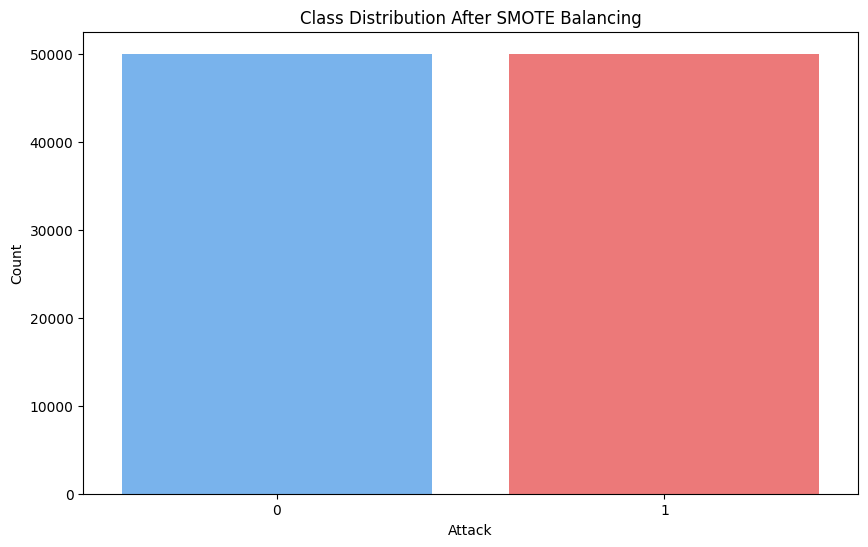

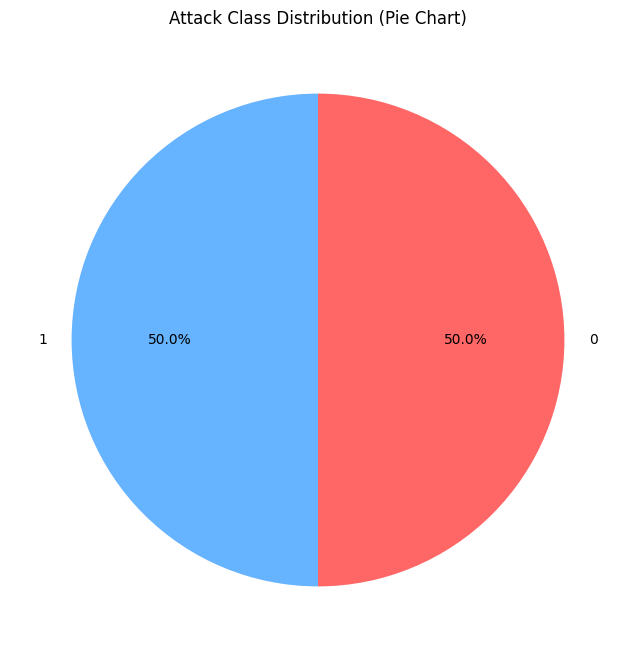

In [16]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\skill\combined_dataset.csv", low_memory=False)

# Ensure 'attack' is numeric
df['attack'] = pd.to_numeric(df['attack'], errors='coerce')
df.dropna(subset=['attack'], inplace=True)

# Separate features and target
X = df.drop(columns=['attack'])
y = df['attack']

# Encode non-numeric columns (required for SMOTE)
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# Apply SMOTE to upsample class 0 to 50,000
smote = SMOTE(sampling_strategy={0: 50000}, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Create the balanced DataFrame
df_smote = pd.DataFrame(X_smote, columns=X.columns)
df_smote['attack'] = y_smote

# Take 50k from the large class 1 to balance
df_class1 = df_smote[df_smote['attack'] == 1].sample(n=50000, random_state=42)
df_class0 = df_smote[df_smote['attack'] == 0]

# Combine and shuffle
df_final = pd.concat([df_class0, df_class1]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced dataset
output_path = r"C:\Users\DELL\OneDrive\Desktop\skill\balanced_1lakh_dataset.csv"
df_final.to_csv(output_path, index=False)

# Confirm class distribution
print("Final class distribution:\n", df_final['attack'].value_counts())
print("Total rows:", len(df_final))
print("Saved to:", output_path)

# Graph: Countplot (Bar Chart) — Updated to avoid FutureWarning
plt.figure(figsize=(10, 6))
sns.countplot(x='attack', hue='attack', data=df_final, palette=['#66b3ff', '#ff6666'], legend=False)
plt.title('Class Distribution After SMOTE Balancing')
plt.xlabel('Attack')
plt.ylabel('Count')
plt.show()

# Graph: Pie Chart
plt.figure(figsize=(8, 8))
df_final['attack'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
plt.title('Attack Class Distribution (Pie Chart)')
plt.ylabel('')
plt.show()


Cleaning

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the new balanced dataset
df = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\skill\balanced_1lakh_dataset.csv")

# Display initial information
print("Initial dataset shape:", df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())

# Handle missing values
# Option 1: Drop rows with any missing values
df_clean = df.dropna()
print("\nShape after dropping missing values:", df_clean.shape)

# Option 2: Fill missing values based on data type
df_clean = df.copy()

# For numeric columns, fill with median
numeric_cols = df_clean.select_dtypes(include=['number']).columns
for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# For categorical columns, fill with mode
categorical_cols = df_clean.select_dtypes(exclude=['number']).columns
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

print("\nShape after filling missing values:", df_clean.shape)

# Remove duplicates
df_clean = df_clean.drop_duplicates()
print("\nShape after removing duplicates:", df_clean.shape)

# Handle outliers using IQR method for numeric columns
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip values to bounds
    df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)

print("\nShape after handling outliers:", df_clean.shape)

# Standardize numeric columns to scale features to mean 0 and variance 1
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

print("\nStandardization complete. Shape after standardization:", df_clean.shape)

# Save the cleaned and standardized dataset
output_path = "C:/Users/DELL/OneDrive/Desktop/skill/cleaned_standardized_1lakh_dataset.csv"
print("\nCleaning and standardization completed. Saving cleaned and standardized dataset...")
df_clean.to_csv(output_path, index=False)
print(f"Cleaned and standardized dataset saved successfully at:\n{output_path}")


Initial dataset shape: (100000, 46)

Missing values per column:
pkSeqID                             0
stime                               0
flgs                                0
flgs_number                         0
proto                               0
proto_number                        0
saddr                               0
sport                               0
daddr                               0
dport                               0
pkts                                0
bytes                               0
state                               0
state_number                        0
ltime                               0
seq                                 0
dur                                 0
mean                                0
stddev                              0
sum                                 0
min                                 0
max                                 0
spkts                               0
dpkts                               0
sbytes                  

Now I want to see whether My Dataset is Encoded or Not!

In [18]:
import pandas as pd

# Load the cleaned and standardized dataset
df = pd.read_csv("C:/Users/DELL/OneDrive/Desktop/skill/cleaned_standardized_1lakh_dataset.csv")

# Check the data types of all columns
print("Data types of columns:")
print(df.dtypes)

# Check for categorical columns (non-numeric columns)
categorical_cols = df.select_dtypes(exclude=['number']).columns
print("\nCategorical columns (non-numeric):")
print(categorical_cols)

# Check unique values in the categorical columns
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())

# Check if any of these categorical columns have strings (indicating they are not encoded yet)
for col in categorical_cols:
    print(f"\nColumn: '{col}'")
    print(f" - Data type: {df[col].dtype}")
    print(f" - Number of unique values: {df[col].nunique()}")
    print(f" - Sample unique values: {df[col].unique()[:5]}")
    if df[col].dtype == 'object':
        print(" → May require encoding.")
    else:
        print(" → Already numeric or encoded.")

Data types of columns:
pkSeqID                             float64
stime                               float64
flgs                                float64
flgs_number                         float64
proto                               float64
proto_number                        float64
saddr                               float64
sport                               float64
daddr                               float64
dport                               float64
pkts                                float64
bytes                               float64
state                               float64
state_number                        float64
ltime                               float64
seq                                 float64
dur                                 float64
mean                                float64
stddev                              float64
sum                                 float64
min                                 float64
max                                 float64
spkts    

Data Preprocessing

In [19]:
import pandas as pd

# Load the dataset
df = pd.read_csv("C:/Users/DELL/OneDrive/Desktop/skill/cleaned_standardized_1lakh_dataset.csv")

# Check if there are any missing values
if df.isnull().sum().any():
    print("There are missing values.")
else:
    print("No missing values detected.")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Save the processed (scaled) dataset (optional)
df_scaled.to_csv("scaled_dataset.csv", index=False)

# View the result after scaling (if done)
print(df_scaled.head())


No missing values detected.
    pkSeqID     stime  flgs  flgs_number     proto  proto_number     saddr  \
0 -1.791269  1.016891   0.0          0.0  0.643493      0.649713 -0.669336   
1 -1.582495  1.016925   0.0          0.0  0.643493      0.649713 -0.669336   
2  0.758320 -0.976747   0.0          0.0  0.643493      0.649713 -1.099154   
3 -1.755987  1.016892   0.0          0.0  0.643493      0.649713 -0.669336   
4 -0.808767  1.029307   0.0          0.0 -0.838471     -1.538625 -0.669336   

      sport     daddr     dport  ...  AR_P_Proto_P_DstIP  N_IN_Conn_P_DstIP  \
0  1.464148 -0.462519  0.799881  ...           -0.647016           1.120066   
1 -1.706439 -0.462519  0.799881  ...           -0.643701           0.714120   
2  0.698009  2.198371 -0.439959  ...            1.980233          -0.796903   
3 -1.244817 -0.462519  0.799881  ...           -0.646785           1.120066   
4 -0.334826 -0.652583  0.799881  ...           -0.645279           1.120066   

   N_IN_Conn_P_SrcIP  AR_P_P

Data Visualisation

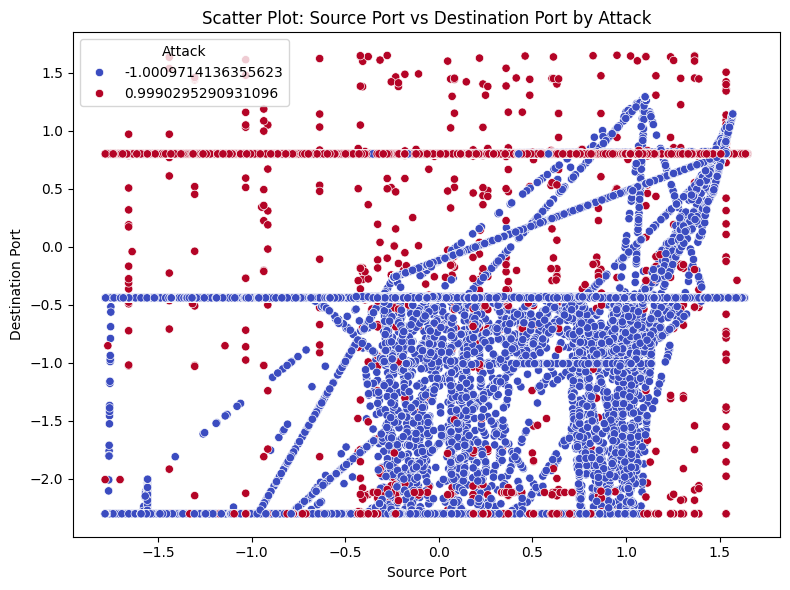

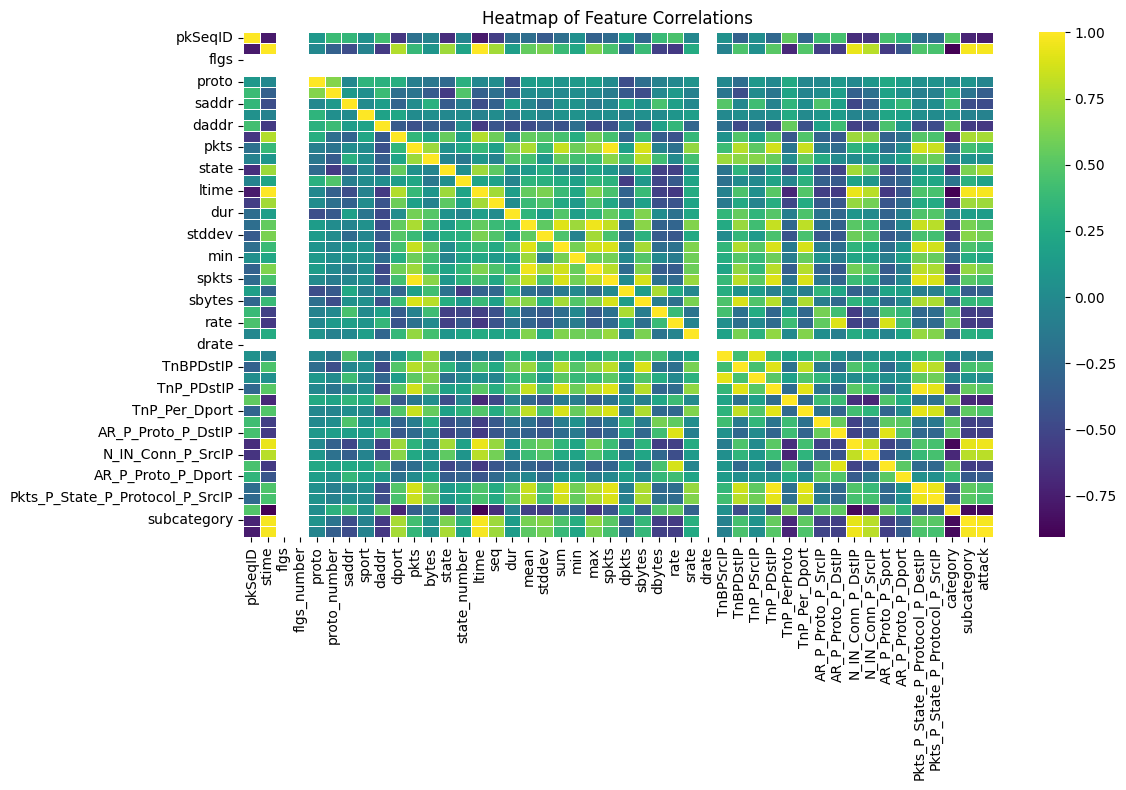

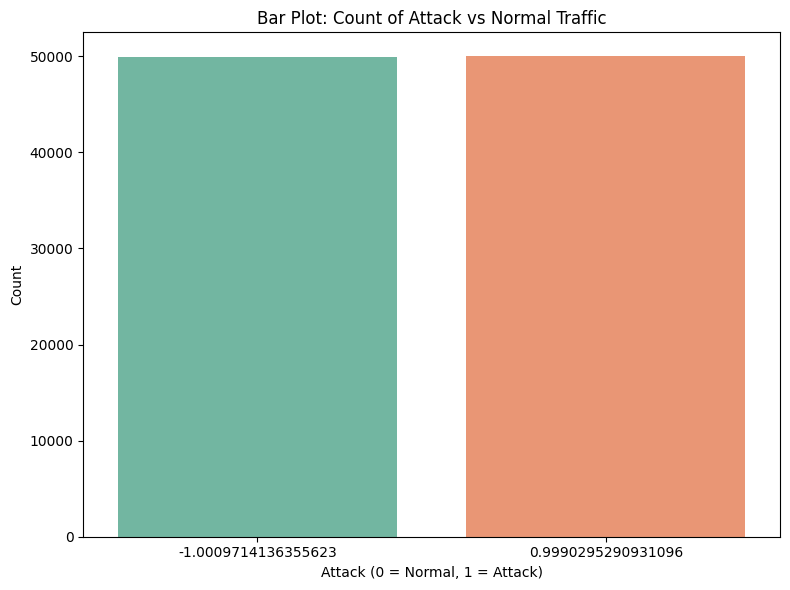

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed dataset
df = pd.read_csv("C:/Users/DELL/OneDrive/Desktop/skill/cleaned_standardized_1lakh_dataset.csv")

# ===== SCATTER PLOT =====
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='sport', y='dport', hue='attack', palette='coolwarm')
plt.title("Scatter Plot: Source Port vs Destination Port by Attack")
plt.xlabel("Source Port")
plt.ylabel("Destination Port")
plt.legend(title='Attack')
plt.tight_layout()
plt.show()

# ===== HEATMAP =====
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, cmap='viridis', annot=False, linewidths=0.5)
plt.title("Heatmap of Feature Correlations")
plt.tight_layout()
plt.show()

# ===== BAR PLOT =====
plt.figure(figsize=(8, 6))
attack_counts = df['attack'].value_counts().sort_index()
sns.barplot(x=attack_counts.index, y=attack_counts.values, hue=attack_counts.index, palette='Set2', legend=False)
plt.title("Bar Plot: Count of Attack vs Normal Traffic")
plt.xlabel("Attack (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Min-Max Normalisation

In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the preprocessed dataset
df = pd.read_csv("scaled_dataset.csv")

# Select numeric columns for normalization
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the numeric columns using Min-Max scaling
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Display the first few rows of the normalized dataset
print("First few rows of the normalized dataset:")
print(df.head())

# Save the normalized dataset to a new CSV file
df.to_csv("normalized_dataset.csv", index=False)

print("\nMin-Max normalization completed and saved to 'normalized_dataset.csv'.")


First few rows of the normalized dataset:
    pkSeqID     stime  flgs  flgs_number  proto  proto_number     saddr  \
0  0.174425  0.573281   0.0          0.0    1.0           0.5  0.210526   
1  0.239990  0.573291   0.0          0.0    1.0           0.5  0.210526   
2  0.975110  0.002077   0.0          0.0    1.0           0.5  0.105263   
3  0.185505  0.573281   0.0          0.0    1.0           0.5  0.210526   
4  0.482975  0.576838   0.0          0.0    0.6           0.0  0.210526   

      sport     daddr     dport  ...  AR_P_Proto_P_DstIP  N_IN_Conn_P_DstIP  \
0  0.945636  0.263158  0.784878  ...            0.007159           1.000000   
1  0.022170  0.263158  0.784878  ...            0.008412           0.818182   
2  0.722490  1.000000  0.470927  ...            1.000000           0.141414   
3  0.156622  0.263158  0.784878  ...            0.007246           1.000000   
4  0.421666  0.210526  0.784878  ...            0.007816           1.000000   

   N_IN_Conn_P_SrcIP  AR_P_Proto

Train Test Split

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the preprocessed and resampled dataset
df = pd.read_csv("normalized_dataset.csv")

# Check the columns in the dataset to make sure 'category' and 'subcategory' exist
print(df.columns)

# Select features and target variable
X = df.drop(columns=['attack'])
y = df['attack']  # Target variable

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the resulting datasets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Optionally, display class distribution in the train and test sets
print("\nClass distribution in the training set:")
print(y_train.value_counts())

print("\nClass distribution in the test set:")
print(y_test.value_counts())


Index(['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number',
       'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state',
       'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min',
       'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
       'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto',
       'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
       'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport',
       'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP',
       'Pkts_P_State_P_Protocol_P_SrcIP', 'category', 'subcategory', 'attack'],
      dtype='object')
Training set size: 79922 samples
Test set size: 19981 samples

Class distribution in the training set:
attack
1.0    39995
0.0    39927
Name: count, dtype: int64

Class distribution in the test set:
attack
1.0    10005
0.0     9976
Name: count, dtype: int64


Pearsons Correlation Test


Pearson Correlation Matrix:
                                   pkSeqID     stime  flgs  flgs_number  \
pkSeqID                           1.000000 -0.773991   NaN          NaN   
stime                            -0.773991  1.000000   NaN          NaN   
flgs                                   NaN       NaN   NaN          NaN   
flgs_number                            NaN       NaN   NaN          NaN   
proto                             0.113968 -0.016724   NaN          NaN   
proto_number                      0.396218 -0.318580   NaN          NaN   
saddr                             0.354411 -0.458605   NaN          NaN   
sport                             0.049818 -0.057867   NaN          NaN   
daddr                             0.423435 -0.579295   NaN          NaN   
dport                            -0.606083  0.777476   NaN          NaN   
pkts                             -0.204879  0.373554   NaN          NaN   
bytes                            -0.066674  0.086275   NaN          NaN

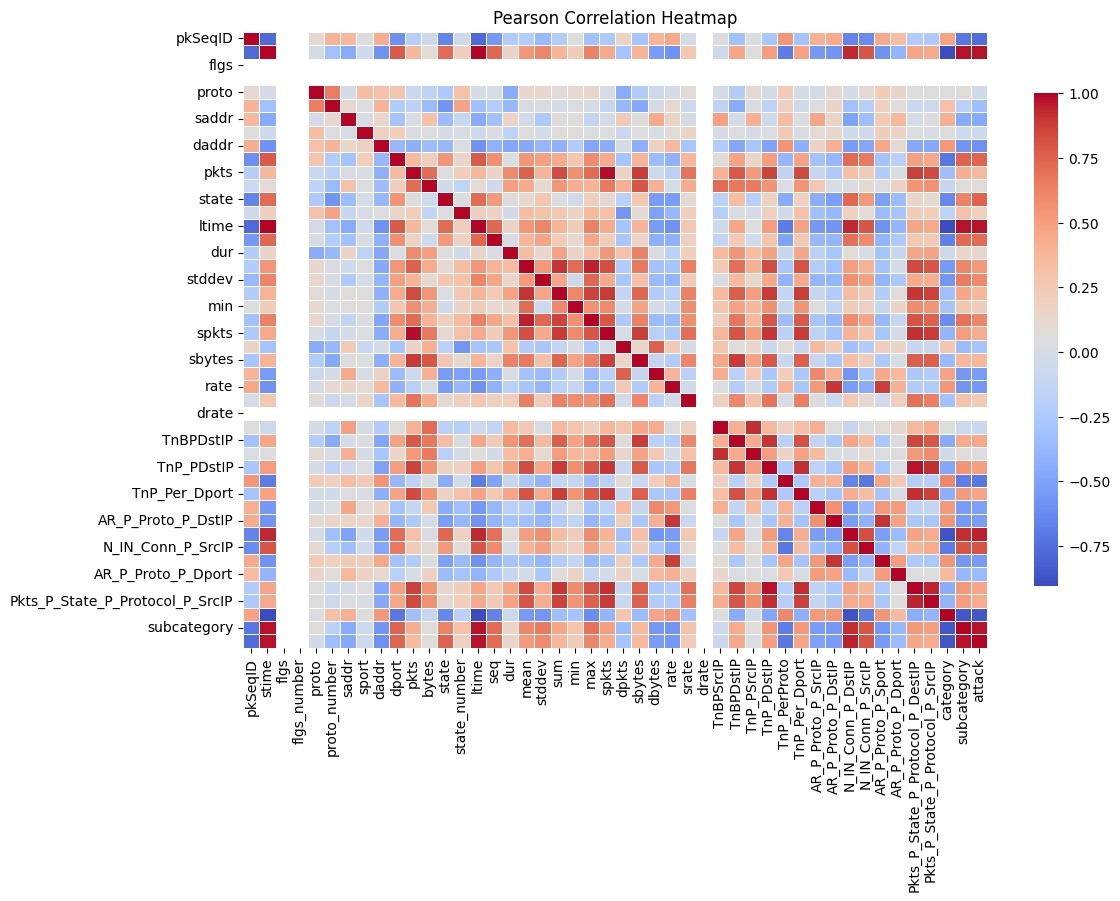


Important Features:
AR_P_Proto_P_DstIP
AR_P_Proto_P_Sport
AR_P_Proto_P_SrcIP
N_IN_Conn_P_DstIP
N_IN_Conn_P_SrcIP
TnP_PerProto
category
daddr
dbytes
dport
ltime
max
mean
pkSeqID
rate
seq
state
stddev
stime
subcategory


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed dataset (or use the balanced dataset if needed)
df = pd.read_csv("normalized_dataset.csv")

# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Compute the Pearson correlation matrix for the numeric columns
correlation_matrix = df[numeric_cols].corr(method='pearson')

# Display the correlation matrix
print("\nPearson Correlation Matrix:")
print(correlation_matrix)

# Plotting the heatmap without numbers inside the boxes
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Pearson Correlation Heatmap")
plt.show()

# Print the important features (based on correlation threshold and the target variable)
target = 'attack'
threshold = 0.5

if target in correlation_matrix.columns:
    important_features = correlation_matrix[target][(correlation_matrix[target].abs() > threshold) & (correlation_matrix[target].abs() < 1.0)].index.tolist()
else:
    important_features = []

print("\nImportant Features:")
for feature in sorted(important_features):
    print(feature)


Recursive Feature Elimination

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Load the normalized and preprocessed dataset
df = pd.read_csv("normalized_dataset.csv")

# Define features and target
X = df.drop(columns=['attack', 'category', 'subcategory'])
y = df['attack']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE to select top 10 features
rfe = RFE(estimator=rf_model, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
print("Selected Features (RFE):")
print(selected_features)

# Train model on selected features
rf_model.fit(X_train[selected_features], y_train)

# Evaluate model
train_acc = rf_model.score(X_train[selected_features], y_train)
test_acc = rf_model.score(X_test[selected_features], y_test)
print(f"\nTrain Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

# Cross-validation scores
cv_scores = cross_val_score(rf_model, X_train[selected_features], y_train, cv=5)
print(f"\nCross-validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")

# Evaluation metrics
y_pred = rf_model.predict(X_test[selected_features])
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Selected Features (RFE):
Index(['pkSeqID', 'stime', 'dport', 'state', 'ltime', 'TnP_PDstIP',
       'TnP_PerProto', 'TnP_Per_Dport', 'N_IN_Conn_P_DstIP',
       'Pkts_P_State_P_Protocol_P_DestIP'],
      dtype='object')

Train Accuracy: 1.00
Test Accuracy: 1.00

Cross-validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.00

Confusion Matrix:
[[ 9981     0]
 [    0 10000]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9981
         1.0       1.00      1.00      1.00     10000

    accuracy                           1.00     19981
   macro avg       1.00      1.00      1.00     19981
weighted avg       1.00      1.00      1.00     19981



Logistic Regression

In [26]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load and clean the dataset
df = pd.read_csv("normalized_dataset.csv")
X = df.drop(columns=['attack', 'category', 'subcategory'], errors='ignore')
y = df['attack']

# Convert to numeric and handle NaNs
X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())
X = X.dropna(axis=1)  # Drop columns with remaining NaNs if any

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression with L1 regularization
log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

# Feature selection
sfm = SelectFromModel(log_reg, threshold="mean", max_features=10)
sfm.fit(X_train, y_train)
selected_features = X.columns[sfm.get_support()]
print("Selected Features:\n", selected_features)

# Evaluate model
y_pred = log_reg.predict(X_test)
print(f"\nTrain Accuracy: {accuracy_score(y_train, log_reg.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Selected Features:
 Index(['stime', 'proto_number', 'daddr', 'state', 'ltime', 'dur', 'rate',
       'TnP_PerProto', 'N_IN_Conn_P_DstIP', 'AR_P_Proto_P_Sport'],
      dtype='object')

Train Accuracy: 1.00
Test Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9976
         1.0       1.00      1.00      1.00     10005

    accuracy                           1.00     19981
   macro avg       1.00      1.00      1.00     19981
weighted avg       1.00      1.00      1.00     19981

Confusion Matrix:
 [[ 9976     0]
 [    0 10005]]


Bagging


=== Voting Classifier Results ===
Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[ 9981     0]
 [    0 10000]]


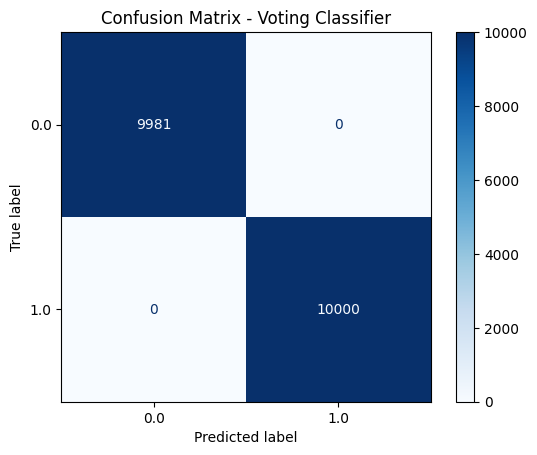


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9981
         1.0       1.00      1.00      1.00     10000

    accuracy                           1.00     19981
   macro avg       1.00      1.00      1.00     19981
weighted avg       1.00      1.00      1.00     19981



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("normalized_dataset.csv")

# Drop target-related columns
X = df.drop(columns=['attack', 'category', 'subcategory'])
y = df['attack']

# Handle non-numeric columns if any
non_numeric_cols = X.select_dtypes(include=['object']).columns
for col in non_numeric_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill missing values
X = X.fillna(X.mean())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize individual classifiers
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf4 = SVC(probability=True, random_state=42)

# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('Logistic Regression', clf1),
        ('Random Forest', clf2),
        ('Gradient Boosting', clf3),
        ('SVM', clf4)
    ],
    voting='soft'  # Use 'soft' for probability-based averaging
)

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Predict
y_pred = voting_clf.predict(X_test)

# Accuracy
train_acc = voting_clf.score(X_train, y_train)
test_acc = voting_clf.score(X_test, y_test)

print("\n=== Voting Classifier Results ===")
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

# Evaluation metrics
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Voting Classifier")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Training and Accuracy

Train Accuracy: 1.00
Test Accuracy: 1.00

Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9976
         1.0       1.00      1.00      1.00     10005

    accuracy                           1.00     19981
   macro avg       1.00      1.00      1.00     19981
weighted avg       1.00      1.00      1.00     19981



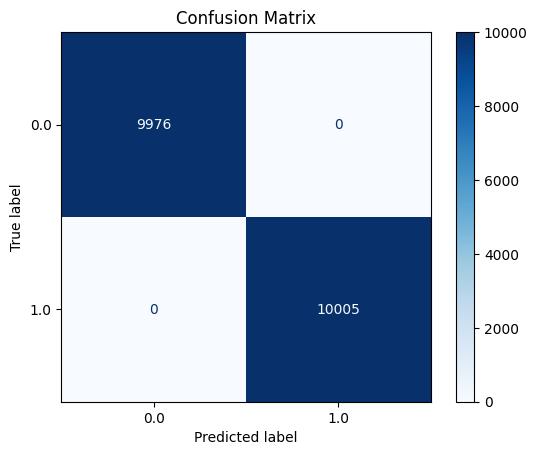

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score
)

# Load dataset
df = pd.read_csv("normalized_dataset.csv")

# Drop target-related columns from features
X = df.drop(columns=['attack', 'category', 'subcategory'])
y = df['attack']

# Convert object-type columns to numeric (handle string issues like 'e')
non_numeric_cols = X.select_dtypes(include=['object']).columns
for col in non_numeric_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill NaNs with column mean
X = X.fillna(X.mean())

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

# Precision, Recall, F1
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()
